In [1]:
import numpy as np
from scipy.stats import skew
import scipy.stats as stats
from scipy.stats import skew
import matplotlib.pyplot as plt



import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display

from xgboost import XGBRegressor

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression


import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [4]:
#1. Drop all the rows with missing data.
data=pd.read_csv('StudyLogistic_Li.csv');
data=data.dropna(axis=0) 
print('shape of train_data'+ str(data.shape) );
print( list(data.columns) )
print( data.describe() )

shape of train_data(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp_var_rate  

In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [5]:
data.loc[:, 'education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [6]:
data.loc[ (data['education']=='basic.4y')| (data['education']=='basic.6y')| (data['education']=='basic.9y'), 'education']
data= data.replace({'education': {'basic.4y': 'basic', 'basic.6y': 'basic', 'basic.9y': 'basic'} } );
#data.loc[ (data['education']=='basic.4y')| (data['education']=='basic.6y')| (data['education']=='basic.9y'), 'education']

In [7]:
data.loc[:, 'education'].unique()

array(['basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

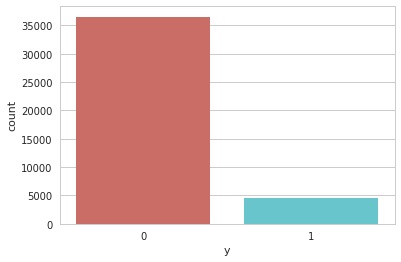

In [8]:
#2.1. Data analysis: unitary data analysis
sns.countplot(x='y',data=data, palette='hls')
plt.show()

In [9]:
#Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11. We need to balance the classes. 
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


In [10]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [ ]:
Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't. The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [11]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [12]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [13]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


Text(0,0.5,'Frequency of Purchase')

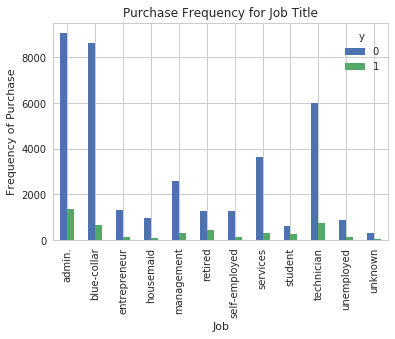

In [14]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

Text(0,0.5,'Proportion of Customers')

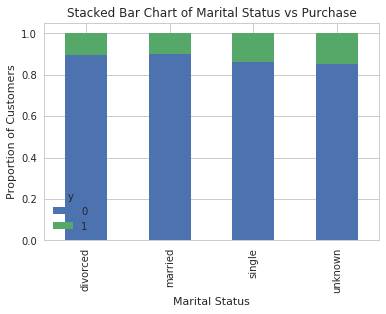

In [15]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Text(0,0.5,'Proportion of Customers')

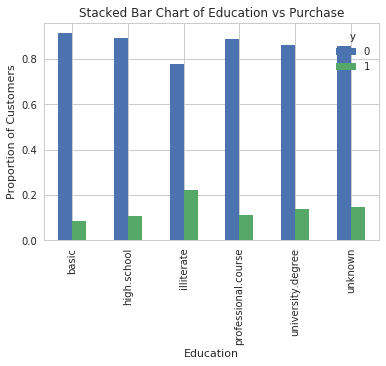

In [23]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Text(0,0.5,'Frequency of Purchase')

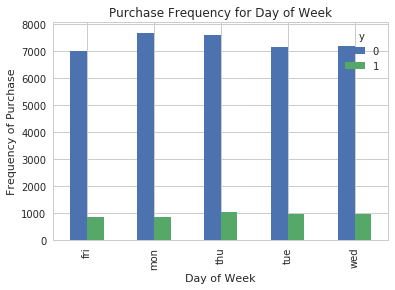

In [24]:

pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')

Text(0,0.5,'Frequency of Purchase')

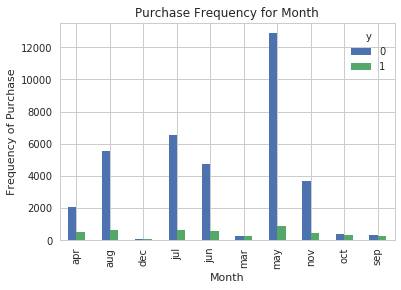

In [25]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Text(0,0.5,'Frequency')

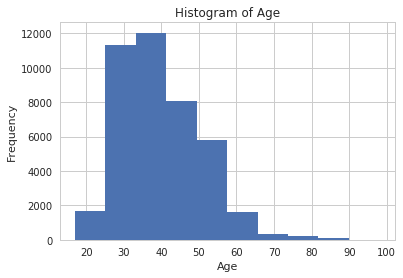

In [26]:

data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency of Purchase')

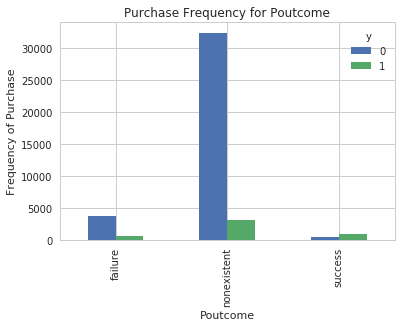

In [27]:

pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

In [29]:
#3. Create dummy variables.
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_cat=data[ cat_vars].copy();
data_drop=data.drop( cat_vars, axis=1);

data_cat=pd.get_dummies(data_cat);
data_dummy=pd.concat([data_drop, data_cat], axis=1);
data_dummy.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

In [35]:
#4. balance the two categories: y=0; y=1;
from imblearn.over_sampling import SMOTE
X= data_dummy.loc[:, data_dummy.columns !='y'];
y= data_dummy.loc[:, 'y'];

os=SMOTE(random_state=0);
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=0);

os_data_X, os_data_y= os.fit_sample(X_train, y_train);
os_data_X= pd.DataFrame( data= os_data_X, columns= X_train.columns );
os_data_y= pd.DataFrame( data= os_data_y, columns=['y'] );

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data", sum(os_data_y['y']==0) );
print("Number of subscription",sum(os_data_y['y']==1) );
print("Proportion of no subscription data in oversampled data is ",sum(os_data_y['y']==0)/len(os_data_X) )
print("Proportion of subscription data in oversampled data is ",sum(os_data_y['y']==1)/len(os_data_X) )


length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [36]:
#5. Recursive feature elimination to select the features.
y_columns=['y'];
X_columns=[i for i in data_dummy if i!= 'y'];

In [43]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y['y'].values );
print(rfe.support_)
print(rfe.ranking_)


/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

[False False False False False False False False  True False False  True
 False  True False False  True False False False False False False False
 False  True False False  True False False False  True  True False False
 False False False False False  True  True  True  True  True  True  True
 False  True  True False  True False False False False False  True False
  True]
[39 36 24 40  9 13 22 35  1 31  7  1  6  1  4 30  1  3 27  2  5 10 20 19
 15  1 14 18  1 17 16 21  1  1 41 25 38 33 29 37 32  1  1  1  1  1  1  1
 12  1  1 34  1 28 11 26 42 23  1  8  1]


In [51]:
X_selected.columns

Index(['euribor3m', 'job_blue-collar', 'job_housemaid', 'job_self-employed',
       'marital_unknown', 'education_illiterate', 'default_no',
       'default_unknown', 'contact_cellular', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_may',
       'month_nov', 'month_sep', 'poutcome_failure', 'poutcome_success'],
      dtype='object')

In [52]:
cols=X_train.columns[ rfe.support_];
X_selected=os_data_X[cols]
y_selected=os_data_y['y']

#Implementing the model
import statsmodels.api as sm
logit_model=sm.Logit(y_selected, X_selected)
result=logit_model.fit()
print(result.summary2() )

         Current function value: 0.545860
         Iterations: 35
                                Results: Logit
Model:                   Logit                No. Iterations:       35.0000   
Dependent Variable:      y                    Pseudo R-squared:     0.212     
Date:                    2019-02-17 01:31     AIC:                  55863.9960
No. Observations:        51134                BIC:                  56040.8401
Df Model:                19                   Log-Likelihood:       -27912.   
Df Residuals:            51114                LL-Null:              -35443.   
Converged:               0.0000               Scale:                1.0000    
------------------------------------------------------------------------------
                      Coef.    Std.Err.    z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
euribor3m             -0.4637    0.0091 -50.9870 0.0000     -0.4815    -0.4459
job_blue-collar   

/home/xiaoling/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [61]:
#6. The p_values for fours variables are very high, remove them;
cols_remove=['default_no','default_unknown','contact_cellular','contact_telephone'];
cols_removed=[i for i in cols if i not in cols_remove]
X_removed= X_selected[cols_removed];
y_removed= y_selected;

In [62]:

logit_model=sm.Logit(y_removed, X_removed);
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.577343
         Iterations 7
                           Results: Logit
Model:                Logit             No. Iterations:    7.0000    
Dependent Variable:   y                 Pseudo R-squared:  0.167     
Date:                 2019-02-17 01:42  AIC:               59075.7419
No. Observations:     51134             BIC:               59217.2172
Df Model:             15                Log-Likelihood:    -29522.   
Df Residuals:         51118             LL-Null:           -35443.   
Converged:            1.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m            -0.3672   0.0070 -52.3248 0.0000 -0.3809 -0.3534
job_blue-collar      -0.1654   0.0274  -6.0315 0.0000 -0.2192 -0.1117
job_housemaid   

In [64]:
#Logistic Regression Model Fitting
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train_rem, X_val_rem, y_train_rem, y_val_rem = train_test_split(X_removed, y_removed, test_size=0.3, random_state=0)
logreg = LogisticRegression(solver='lbfgs' )
logreg.fit(X_train_rem, y_train_rem)

/home/xiaoling/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [66]:
y_pred = logreg.predict(X_val_rem)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_val_rem, y_val_rem)))

Accuracy of logistic regression classifier on test set: 0.74


In [67]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val_rem, y_pred)
print(confusion_matrix)

[[6154 1512]
 [2511 5164]]


In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_val_rem, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      7666
           1       0.77      0.67      0.72      7675

   micro avg       0.74      0.74      0.74     15341
   macro avg       0.74      0.74      0.74     15341
weighted avg       0.74      0.74      0.74     15341



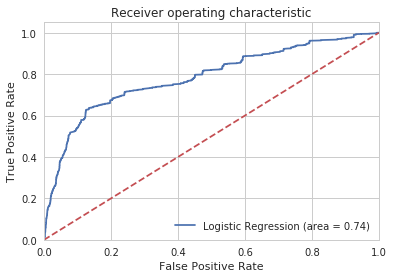

In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_val_rem, logreg.predict(X_val_rem) )
fpr, tpr, thresholds = roc_curve(y_val_rem, logreg.predict_proba(X_val_rem)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()